In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

from lime.lime_tabular import LimeTabularExplainer
import shap
from collections import defaultdict

In [2]:
wine_qt_path = '../data/WineQT.csv'
RANDOM_SEED = 492

In [3]:
wine_df = pd.read_csv(wine_qt_path)

In [4]:
print(wine_df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Id  
0      9.4        5   0  
1      9.8        5   1  
2      9

In [5]:
y_series = wine_df['quality']
y = pd.DataFrame(y_series, columns=['quality'])
features = [col for col in wine_df.columns if col != 'Id' and col != 'quality']
X = wine_df[features]

In [6]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_series)
y_encoded = pd.DataFrame(y_encoded, columns=['quality'])
print(y_encoded)

      quality
0           2
1           2
2           2
3           3
4           2
...       ...
1138        3
1139        3
1140        2
1141        3
1142        2

[1143 rows x 1 columns]


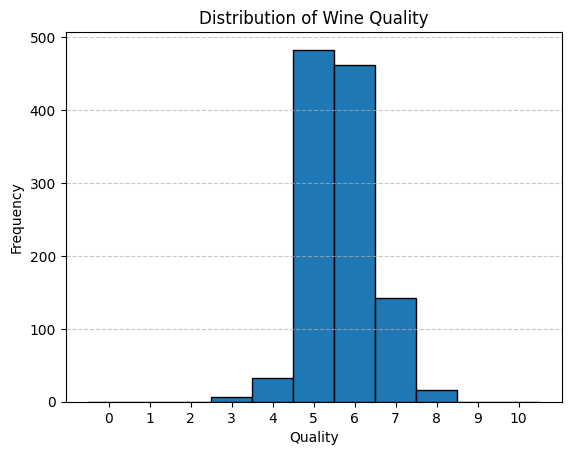

In [7]:
# Plot histogram of y_series
plt.hist(y_series, bins=range(0, 12), align='left', edgecolor='black')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Distribution of Wine Quality')
plt.xticks(range(0, 11))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
# Get the minimum and maximum values from y_series
min_quality = y_series.min()
max_quality = y_series.max()

print("Minimum quality:", min_quality)
print("Maximum quality:", max_quality)

Minimum quality: 3
Maximum quality: 8


In [9]:
unique_values = y_series.unique()
print("Unique values in y_series:", unique_values)

Unique values in y_series: [5 6 7 4 8 3]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=RANDOM_SEED)

In [11]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [13]:
class GradientBoostedTreesEnsembleClassifier(tf.keras.Model):
    def __init__(self, n_trees=100, max_depth=3, n_estimators=100, subportion = 0.8, sample_method='RANDOM'): 
        super(GradientBoostedTreesEnsembleClassifier, self).__init__()
        self.n_trees = n_trees
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.subportion = subportion
        self.sample_method = sample_method
        self.estimators = []
        self.lime_explainers = []
        self.shap_explainers = []

    def build_estimator(self):
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.CLASSIFICATION,
            num_trees=np.random.randint(self.n_trees//5, self.n_trees+1), # self.n_trees, #
            max_depth=self.max_depth, #np.random.randint(self.max_depth/2, self.max_depth+1), # self.max_depth, # 
            validation_ratio=0.1,
            subsample=self.subportion,
            sampling_method=self.sample_method,
            random_seed=self.seed # try to set this first. Maybe this is enough
        )
        return model

    def fit(self, X, y):
        
        X_tensor = tf.constant(X.values, dtype=tf.float32)
        y_tensor = tf.constant(y.values, dtype=tf.float32)
        tot_dataset_size = len(X)
        
        for seed in np.random.randint(0, 1000000, size=self.n_estimators):
            self.seed = int(seed)
            subset_size = int(self.subportion * tot_dataset_size)
            
            # Create a subset of the dataset using sampled indices
            subset_indices = np.random.choice(tot_dataset_size, size=subset_size, replace=False)
            X_subset = tf.gather(X_tensor, subset_indices)
            y_subset = tf.gather(y_tensor, subset_indices)
            
            # subset_dataset = (X_tensor, y_tensor)
            
            # building each estimator
            estimator = self.build_estimator()
            estimator.fit(X_subset,y_subset,verbose=0)
            self.estimators.append(estimator)
        
        # initiate explainers
        for model in self.estimators:
            lime_explainer = LimeTabularExplainer(X.values, feature_names=X.columns.tolist(), mode='classification')
            self.lime_explainers.append(lime_explainer)
            masker = shap.maskers.Independent(data = X_train.values)
            shap_explainer = shap.Explainer(model, masker=masker, feature_names=X.columns.tolist())
            self.shap_explainers.append(shap_explainer)
    
    
    def predict_mean(self, X): # use all estimators
        X_tensor = tf.constant(X.values, dtype=tf.float32)
        predictions = []
        
        for i, estimator in enumerate(self.estimators):
            estimator_predictions = estimator.predict(X_tensor)  # Get predictions from the current estimator
            print(f"Shape of prediction from estimator {i}: {estimator_predictions.shape}")  # Print the shape
            predictions.append(estimator_predictions)
            
        predictions_stacked = np.stack(predictions, axis=-1)
        
        mean_prediction = np.mean(predictions_stacked, axis=-1)
        sd_prediction = np.std(predictions_stacked, axis=-1)
        return mean_prediction, sd_prediction
    
    def explain_lime(self, X):
        lime_explanations = []
        
        for estimator, explainer in zip(self.estimators, self.lime_explainers):
            for i in range(len(X)): 
                instance_explanation = explainer.explain_instance(X.iloc[i], estimator.predict, num_features=X.shape[1])
                lime_explanations.append(instance_explanation)
        return lime_explanations
    
    def explain_shap(self, X):
        shap_values = []
        
        for estimator, explainer in zip(self.estimators, self.shap_explainers):
            shap_value = explainer(X)
            shap_values.append(shap_value)
        
        return shap_values


In [14]:
gbt_model = GradientBoostedTreesEnsembleClassifier(
    n_trees=50, 
    max_depth=5, 
    n_estimators=80, 
    subportion=0.8, 
    sample_method='RANDOM'
)

In [15]:
gbt_model.fit(X_train_scaled, y_train)

Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkmes2tks as temporary training directory


[WARNING 24-06-13 03:53:03.5794 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:03.5800 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:03.5800 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-06-13 03:53:05.8639 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkmes2tks/model/ with prefix 3d9da433f584476e
[INFO 24-06-13 03:53:05.8672 CEST decision_forest.cc:734] Model loaded with 132 root(s), 2760 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:05.8673 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesGeneric" built
[INFO 24-06-13 03:53:05.8673 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppeoo4kpo as temporary training directory


[WARNING 24-06-13 03:53:07.9912 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:07.9912 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:07.9912 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9ys_vo7j as temporary training directory


[INFO 24-06-13 03:53:08.2906 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppeoo4kpo/model/ with prefix 08354e72fe9345c1
[INFO 24-06-13 03:53:08.2937 CEST decision_forest.cc:734] Model loaded with 150 root(s), 3032 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:08.2937 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:08.3574 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:08.3575 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:08.3575 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnoato7hr as temporary training directory


[INFO 24-06-13 03:53:08.5827 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9ys_vo7j/model/ with prefix 12ea5bb881144d08
[INFO 24-06-13 03:53:08.5848 CEST decision_forest.cc:734] Model loaded with 90 root(s), 1850 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:08.5848 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:08.6480 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:08.6480 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:08.6480 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpukxgfzdt as temporary training directory


[INFO 24-06-13 03:53:08.9153 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnoato7hr/model/ with prefix 8584451013334ea0
[INFO 24-06-13 03:53:08.9178 CEST decision_forest.cc:734] Model loaded with 114 root(s), 2288 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:08.9178 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:08.9811 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:08.9811 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:08.9811 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


[INFO 24-06-13 03:53:09.3164 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpukxgfzdt/model/ with prefix 64d26f70c8cf4da7
[INFO 24-06-13 03:53:09.3203 CEST decision_forest.cc:734] Model loaded with 192 root(s), 3882 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:09.3203 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1yq2lsrj as temporary training directory


[WARNING 24-06-13 03:53:09.3872 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:09.3872 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:09.3872 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


[INFO 24-06-13 03:53:09.8091 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1yq2lsrj/model/ with prefix c83d3364b13b4ee6
[INFO 24-06-13 03:53:09.8141 CEST decision_forest.cc:734] Model loaded with 246 root(s), 4964 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:09.8141 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmyu1zvb8 as temporary training directory


[WARNING 24-06-13 03:53:09.8802 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:09.8802 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:09.8802 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphyncanyt as temporary training directory


[INFO 24-06-13 03:53:10.1362 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmyu1zvb8/model/ with prefix f3627645f5de4738
[INFO 24-06-13 03:53:10.1388 CEST decision_forest.cc:734] Model loaded with 108 root(s), 2390 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:10.1388 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:10.2021 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:10.2021 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:10.2021 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfxo2nvya as temporary training directory


[INFO 24-06-13 03:53:10.4741 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphyncanyt/model/ with prefix 07b7fed3d0fa4cb2
[INFO 24-06-13 03:53:10.4772 CEST decision_forest.cc:734] Model loaded with 144 root(s), 2938 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:10.4772 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:10.5403 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:10.5404 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:10.5404 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe3tlu2ds as temporary training directory


[INFO 24-06-13 03:53:10.8225 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfxo2nvya/model/ with prefix a16ba34d9b6d49b0
[INFO 24-06-13 03:53:10.8256 CEST decision_forest.cc:734] Model loaded with 138 root(s), 2940 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:10.8257 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:10.8887 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:10.8887 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:10.8887 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpovomnfi7 as temporary training directory


[INFO 24-06-13 03:53:11.1040 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe3tlu2ds/model/ with prefix 58c7e0de5ea74592
[INFO 24-06-13 03:53:11.1065 CEST decision_forest.cc:734] Model loaded with 108 root(s), 2230 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:11.1065 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:11.1696 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:11.1696 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:11.1696 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6bla2oe7 as temporary training directory


[INFO 24-06-13 03:53:11.4477 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpovomnfi7/model/ with prefix 5415ab6231b74e3f
[INFO 24-06-13 03:53:11.4517 CEST decision_forest.cc:734] Model loaded with 186 root(s), 3808 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:11.4518 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:11.5137 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:11.5137 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:11.5138 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5am5u9_j as temporary training directory


[INFO 24-06-13 03:53:11.7868 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6bla2oe7/model/ with prefix 8f6e2bcdd94e4c87
[INFO 24-06-13 03:53:11.7897 CEST decision_forest.cc:734] Model loaded with 126 root(s), 2576 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:11.7897 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:11.8518 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:11.8519 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:11.8519 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2qbavmmm as temporary training directory


[INFO 24-06-13 03:53:12.1274 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5am5u9_j/model/ with prefix ecd4ccba295340e1
[INFO 24-06-13 03:53:12.1307 CEST decision_forest.cc:734] Model loaded with 144 root(s), 3036 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:12.1307 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:12.1932 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:12.1933 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:12.1933 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5kro_903 as temporary training directory


[INFO 24-06-13 03:53:12.4461 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2qbavmmm/model/ with prefix b6e00f7c94674c83
[INFO 24-06-13 03:53:12.4485 CEST decision_forest.cc:734] Model loaded with 114 root(s), 2270 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:12.4486 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:12.5126 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:12.5126 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:12.5126 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5tjsk3ut as temporary training directory


[INFO 24-06-13 03:53:12.7034 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5kro_903/model/ with prefix 6f2c03de74a643c1
[INFO 24-06-13 03:53:12.7053 CEST decision_forest.cc:734] Model loaded with 72 root(s), 1634 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:12.7053 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:12.7682 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:12.7682 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:12.7682 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppdwygp50 as temporary training directory


[INFO 24-06-13 03:53:13.0138 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5tjsk3ut/model/ with prefix bae5ad6930834b6c
[INFO 24-06-13 03:53:13.0166 CEST decision_forest.cc:734] Model loaded with 138 root(s), 2662 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:13.0167 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:13.0808 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:13.0808 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:13.0809 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwlvc1w50 as temporary training directory


[INFO 24-06-13 03:53:13.3865 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppdwygp50/model/ with prefix 137b63da8f754bc1
[INFO 24-06-13 03:53:13.3906 CEST decision_forest.cc:734] Model loaded with 180 root(s), 3858 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:13.3907 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:13.4555 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:13.4555 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:13.4555 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvqchulya as temporary training directory


[INFO 24-06-13 03:53:13.8147 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwlvc1w50/model/ with prefix fe3cb38f029249df
[INFO 24-06-13 03:53:13.8191 CEST decision_forest.cc:734] Model loaded with 210 root(s), 4104 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:13.8191 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:13.8829 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:13.8829 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:13.8829 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwftv988j as temporary training directory


[INFO 24-06-13 03:53:14.0821 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvqchulya/model/ with prefix 85c942570fca4170
[INFO 24-06-13 03:53:14.0844 CEST decision_forest.cc:734] Model loaded with 96 root(s), 1942 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:14.0844 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:14.1462 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:14.1462 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:14.1462 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6gll7ma6 as temporary training directory


[INFO 24-06-13 03:53:14.3258 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwftv988j/model/ with prefix e23ec9607dfd414b
[INFO 24-06-13 03:53:14.3275 CEST decision_forest.cc:734] Model loaded with 72 root(s), 1496 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:14.3275 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:14.3906 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:14.3907 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:14.3907 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj1f1juho as temporary training directory


[INFO 24-06-13 03:53:14.6454 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6gll7ma6/model/ with prefix ed3ee1f2079b4abe
[INFO 24-06-13 03:53:14.6478 CEST decision_forest.cc:734] Model loaded with 102 root(s), 2076 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:14.6478 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:14.7105 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:14.7105 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:14.7105 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp27rs00im as temporary training directory


[INFO 24-06-13 03:53:14.9943 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj1f1juho/model/ with prefix 49cb72f7ae2f4bb6
[INFO 24-06-13 03:53:14.9980 CEST decision_forest.cc:734] Model loaded with 162 root(s), 3276 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:14.9980 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:15.0619 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:15.0620 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:15.0620 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkodt62wf as temporary training directory


[INFO 24-06-13 03:53:15.3567 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp27rs00im/model/ with prefix 48b10d201cc94445
[INFO 24-06-13 03:53:15.3599 CEST decision_forest.cc:734] Model loaded with 150 root(s), 2874 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:15.3599 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:15.4222 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:15.4222 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:15.4222 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2zmd3xub as temporary training directory


[INFO 24-06-13 03:53:15.6473 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkodt62wf/model/ with prefix e0111caa7b824556
[INFO 24-06-13 03:53:15.6501 CEST decision_forest.cc:734] Model loaded with 120 root(s), 2512 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:15.6501 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:15.7156 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:15.7156 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:15.7156 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcal_ixzb as temporary training directory


[INFO 24-06-13 03:53:16.0241 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2zmd3xub/model/ with prefix a688fdaf561b4e8d
[INFO 24-06-13 03:53:16.0278 CEST decision_forest.cc:734] Model loaded with 168 root(s), 3246 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:16.0278 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesGeneric" built
[INFO 24-06-13 03:53:16.0278 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:16.0942 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:16.0942 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:16.0942 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcv7ejj4q as temporary training directory


[INFO 24-06-13 03:53:16.4179 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcal_ixzb/model/ with prefix 50d8276a42af43fc
[INFO 24-06-13 03:53:16.4218 CEST decision_forest.cc:734] Model loaded with 192 root(s), 3754 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:16.4218 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:16.4839 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:16.4839 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:16.4839 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6t6bn_5p as temporary training directory


[INFO 24-06-13 03:53:16.8490 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcv7ejj4q/model/ with prefix 656a06fad6d249ed
[INFO 24-06-13 03:53:16.8521 CEST decision_forest.cc:734] Model loaded with 144 root(s), 2960 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:16.8521 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:16.9162 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:16.9162 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:16.9162 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5jmne0an as temporary training directory


[INFO 24-06-13 03:53:17.1518 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6t6bn_5p/model/ with prefix 32f313224ccb4b90
[INFO 24-06-13 03:53:17.1544 CEST decision_forest.cc:734] Model loaded with 120 root(s), 2404 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:17.1544 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:17.2152 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:17.2152 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:17.2152 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwq01m3uo as temporary training directory


[INFO 24-06-13 03:53:17.4883 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5jmne0an/model/ with prefix 68b2b232435045b0
[INFO 24-06-13 03:53:17.4917 CEST decision_forest.cc:734] Model loaded with 162 root(s), 3240 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:17.4917 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:17.5519 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:17.5519 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:17.5519 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8h7ucidk as temporary training directory


[INFO 24-06-13 03:53:17.8193 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwq01m3uo/model/ with prefix ae083413ed894614
[INFO 24-06-13 03:53:17.8221 CEST decision_forest.cc:734] Model loaded with 126 root(s), 2648 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:17.8221 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:17.8828 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:17.8828 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:17.8828 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1es78zal as temporary training directory


[INFO 24-06-13 03:53:18.1305 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8h7ucidk/model/ with prefix f3c45154723b4209
[INFO 24-06-13 03:53:18.1331 CEST decision_forest.cc:734] Model loaded with 114 root(s), 2468 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:18.1331 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:18.1936 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:18.1936 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:18.1936 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpug915lgs as temporary training directory


[INFO 24-06-13 03:53:18.4329 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1es78zal/model/ with prefix 8755ec4556784aba
[INFO 24-06-13 03:53:18.4354 CEST decision_forest.cc:734] Model loaded with 114 root(s), 2372 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:18.4354 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:18.4961 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:18.4961 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:18.4962 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg3sm6cjp as temporary training directory


[INFO 24-06-13 03:53:18.7330 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpug915lgs/model/ with prefix dcbc7e462a8e4217
[INFO 24-06-13 03:53:18.7358 CEST decision_forest.cc:734] Model loaded with 126 root(s), 2508 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:18.7358 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:18.8010 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:18.8010 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:18.8010 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4ar1qii4 as temporary training directory


[INFO 24-06-13 03:53:19.1232 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg3sm6cjp/model/ with prefix d873e544d17d4617
[INFO 24-06-13 03:53:19.1270 CEST decision_forest.cc:734] Model loaded with 180 root(s), 3672 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:19.1271 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:19.1870 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:19.1870 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:19.1870 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeug1sli0 as temporary training directory


[INFO 24-06-13 03:53:19.4422 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4ar1qii4/model/ with prefix 6067fee48fef43d8
[INFO 24-06-13 03:53:19.4451 CEST decision_forest.cc:734] Model loaded with 132 root(s), 2762 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:19.4451 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:19.5051 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:19.5052 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:19.5052 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyvkal0ie as temporary training directory


[INFO 24-06-13 03:53:19.6943 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeug1sli0/model/ with prefix a1a38a5beb76439f
[INFO 24-06-13 03:53:19.6962 CEST decision_forest.cc:734] Model loaded with 78 root(s), 1670 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:19.6963 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:19.7613 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:19.7613 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:19.7613 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl7tgegwj as temporary training directory


[INFO 24-06-13 03:53:19.9382 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyvkal0ie/model/ with prefix fd79b20b3d2c45a3
[INFO 24-06-13 03:53:19.9400 CEST decision_forest.cc:734] Model loaded with 72 root(s), 1554 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:19.9400 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:19.9991 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:19.9992 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:19.9992 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphe4t794j as temporary training directory


[INFO 24-06-13 03:53:20.2575 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl7tgegwj/model/ with prefix 81cac0fb8def4db7
[INFO 24-06-13 03:53:20.2607 CEST decision_forest.cc:734] Model loaded with 138 root(s), 2874 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:20.2607 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:20.3231 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:20.3231 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:20.3231 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpztf9xkq0 as temporary training directory


[INFO 24-06-13 03:53:20.5438 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphe4t794j/model/ with prefix 0a280b8e28324b3b
[INFO 24-06-13 03:53:20.5460 CEST decision_forest.cc:734] Model loaded with 102 root(s), 2042 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:20.5460 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:20.6083 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:20.6083 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:20.6083 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmihisika as temporary training directory


[INFO 24-06-13 03:53:20.8901 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpztf9xkq0/model/ with prefix 26022c0cbaa243aa
[INFO 24-06-13 03:53:20.8934 CEST decision_forest.cc:734] Model loaded with 156 root(s), 3208 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:20.8934 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:20.9594 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:20.9594 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:20.9594 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkdzjtoqq as temporary training directory


[INFO 24-06-13 03:53:21.2815 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmihisika/model/ with prefix 86c96649e426438f
[INFO 24-06-13 03:53:21.2855 CEST decision_forest.cc:734] Model loaded with 186 root(s), 3708 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:21.2855 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:21.3500 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:21.3500 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:21.3500 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_64zpp44 as temporary training directory


[INFO 24-06-13 03:53:21.6896 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkdzjtoqq/model/ with prefix 4b93a53ce6ef474e
[INFO 24-06-13 03:53:21.6937 CEST decision_forest.cc:734] Model loaded with 192 root(s), 3884 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:21.6937 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:21.7584 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:21.7584 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:21.7584 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgkgxtlo8 as temporary training directory


[INFO 24-06-13 03:53:21.9652 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_64zpp44/model/ with prefix 07786eb89cbb479e
[INFO 24-06-13 03:53:21.9678 CEST decision_forest.cc:734] Model loaded with 120 root(s), 2382 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:21.9678 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:22.0269 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:22.0269 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:22.0270 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb8qdruyc as temporary training directory


[INFO 24-06-13 03:53:22.2696 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgkgxtlo8/model/ with prefix 4409136a4cf44ce3
[INFO 24-06-13 03:53:22.2725 CEST decision_forest.cc:734] Model loaded with 132 root(s), 2818 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:22.2725 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:22.3351 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:22.3351 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:22.3351 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ttrgcig as temporary training directory


[INFO 24-06-13 03:53:22.5006 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb8qdruyc/model/ with prefix c417bc17cf6f43bd
[INFO 24-06-13 03:53:22.5026 CEST decision_forest.cc:734] Model loaded with 84 root(s), 1768 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:22.5026 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:22.5619 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:22.5619 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:22.5620 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpllu9r81k as temporary training directory


[INFO 24-06-13 03:53:22.7974 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ttrgcig/model/ with prefix 8dfdde2b016a4b1b
[INFO 24-06-13 03:53:22.8001 CEST decision_forest.cc:734] Model loaded with 120 root(s), 2448 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:22.8001 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:22.8663 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:22.8663 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:22.8663 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpskz3ca5c as temporary training directory


[INFO 24-06-13 03:53:23.1885 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpllu9r81k/model/ with prefix 4afea7158a334f76
[INFO 24-06-13 03:53:23.1919 CEST decision_forest.cc:734] Model loaded with 162 root(s), 3334 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:23.1920 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:23.2552 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:23.2552 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:23.2553 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmau8rllz as temporary training directory


[INFO 24-06-13 03:53:23.4990 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpskz3ca5c/model/ with prefix cfcba60933244ddc
[INFO 24-06-13 03:53:23.5018 CEST decision_forest.cc:734] Model loaded with 132 root(s), 2674 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:23.5018 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:23.5625 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:23.5625 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:23.5625 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi8w16o3j as temporary training directory


[INFO 24-06-13 03:53:23.8537 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmau8rllz/model/ with prefix 38941c96d9824218
[INFO 24-06-13 03:53:23.8571 CEST decision_forest.cc:734] Model loaded with 150 root(s), 3144 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:23.8571 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:23.9233 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:23.9233 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:23.9233 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnvq44fwe as temporary training directory


[INFO 24-06-13 03:53:24.0981 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi8w16o3j/model/ with prefix 8f489583d7d44d67
[INFO 24-06-13 03:53:24.0999 CEST decision_forest.cc:734] Model loaded with 72 root(s), 1518 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:24.0999 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:24.1663 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:24.1663 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:24.1663 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp8fbvcjf as temporary training directory


[INFO 24-06-13 03:53:24.3438 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnvq44fwe/model/ with prefix f744a992d8e44527
[INFO 24-06-13 03:53:24.3456 CEST decision_forest.cc:734] Model loaded with 72 root(s), 1502 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:24.3456 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:24.4100 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:24.4101 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:24.4101 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr08pof7y as temporary training directory


[INFO 24-06-13 03:53:24.6432 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp8fbvcjf/model/ with prefix bf389174f80e48c0
[INFO 24-06-13 03:53:24.6453 CEST decision_forest.cc:734] Model loaded with 90 root(s), 1920 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:24.6453 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:24.7054 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:24.7054 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:24.7054 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2ihhogrn as temporary training directory


[INFO 24-06-13 03:53:24.9596 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr08pof7y/model/ with prefix 1242ac5b3cb14db5
[INFO 24-06-13 03:53:24.9627 CEST decision_forest.cc:734] Model loaded with 132 root(s), 2774 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:24.9627 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:25.0271 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:25.0271 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:25.0271 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyqxv1vr4 as temporary training directory


[INFO 24-06-13 03:53:25.3552 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2ihhogrn/model/ with prefix 97d89e960c07467b
[INFO 24-06-13 03:53:25.3573 CEST decision_forest.cc:734] Model loaded with 84 root(s), 1838 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:25.3574 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:25.4209 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:25.4209 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:25.4209 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkq3d3iy6 as temporary training directory


[INFO 24-06-13 03:53:25.7283 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyqxv1vr4/model/ with prefix 65b234f1b94048f5
[INFO 24-06-13 03:53:25.7324 CEST decision_forest.cc:734] Model loaded with 192 root(s), 3924 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:25.7324 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:25.7961 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:25.7961 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:25.7961 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp18rcbrpz as temporary training directory


[INFO 24-06-13 03:53:26.0522 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkq3d3iy6/model/ with prefix 68358f82e8e24cf3
[INFO 24-06-13 03:53:26.0550 CEST decision_forest.cc:734] Model loaded with 126 root(s), 2574 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:26.0550 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesGeneric" built
[INFO 24-06-13 03:53:26.0550 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:26.1162 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:26.1162 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:26.1162 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq37ynj0s as temporary training directory


[INFO 24-06-13 03:53:26.2953 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp18rcbrpz/model/ with prefix 3f55d30ef6274dc9
[INFO 24-06-13 03:53:26.2969 CEST decision_forest.cc:734] Model loaded with 66 root(s), 1388 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:26.2969 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:26.3572 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:26.3572 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:26.3572 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe9p33z9n as temporary training directory


[INFO 24-06-13 03:53:26.6849 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq37ynj0s/model/ with prefix db6cca22cf644c24
[INFO 24-06-13 03:53:26.6888 CEST decision_forest.cc:734] Model loaded with 168 root(s), 3558 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:26.6888 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:26.7514 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:26.7514 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:26.7515 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppkfmy61_ as temporary training directory


[INFO 24-06-13 03:53:26.9965 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe9p33z9n/model/ with prefix 0d4612c97422422d
[INFO 24-06-13 03:53:26.9986 CEST decision_forest.cc:734] Model loaded with 96 root(s), 1930 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:26.9986 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:27.0588 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:27.0588 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:27.0588 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsmia42lz as temporary training directory


[INFO 24-06-13 03:53:27.3028 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppkfmy61_/model/ with prefix f2faecbcea654376
[INFO 24-06-13 03:53:27.3057 CEST decision_forest.cc:734] Model loaded with 126 root(s), 2666 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:27.3057 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:27.3663 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:27.3663 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:27.3663 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3q91rdwx as temporary training directory


[INFO 24-06-13 03:53:27.5710 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsmia42lz/model/ with prefix d05049f300d5428d
[INFO 24-06-13 03:53:27.5736 CEST decision_forest.cc:734] Model loaded with 114 root(s), 2410 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:27.5736 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:27.6354 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:27.6355 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:27.6355 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp434erove as temporary training directory


[INFO 24-06-13 03:53:27.9824 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3q91rdwx/model/ with prefix d21c4ed1970b4736
[INFO 24-06-13 03:53:27.9873 CEST decision_forest.cc:734] Model loaded with 234 root(s), 4690 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:27.9874 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:28.0469 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:28.0469 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:28.0469 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3_e2owoa as temporary training directory


[INFO 24-06-13 03:53:28.2854 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp434erove/model/ with prefix 9cf88441bf2443da
[INFO 24-06-13 03:53:28.2877 CEST decision_forest.cc:734] Model loaded with 96 root(s), 2028 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:28.2877 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:28.3476 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:28.3476 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:28.3476 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbkuu43jo as temporary training directory


[INFO 24-06-13 03:53:28.6870 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3_e2owoa/model/ with prefix e5aa4b789b53441e
[INFO 24-06-13 03:53:28.6911 CEST decision_forest.cc:734] Model loaded with 198 root(s), 3976 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:28.6911 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:28.7499 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:28.7499 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:28.7499 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqz3sfj_p as temporary training directory


[INFO 24-06-13 03:53:29.0733 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbkuu43jo/model/ with prefix a19f94a582f04fcc
[INFO 24-06-13 03:53:29.0767 CEST decision_forest.cc:734] Model loaded with 156 root(s), 3346 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:29.0768 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:29.1361 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:29.1361 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:29.1361 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbzf8zn3q as temporary training directory


[INFO 24-06-13 03:53:29.4502 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqz3sfj_p/model/ with prefix ead498803d0540a8
[INFO 24-06-13 03:53:29.4539 CEST decision_forest.cc:734] Model loaded with 168 root(s), 3478 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:29.4540 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:29.5138 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:29.5139 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:29.5139 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpokuwwx56 as temporary training directory


[INFO 24-06-13 03:53:29.8507 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbzf8zn3q/model/ with prefix 6e4398e40b6a4af2
[INFO 24-06-13 03:53:29.8551 CEST decision_forest.cc:734] Model loaded with 210 root(s), 4220 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:29.8551 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:29.9157 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:29.9157 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:29.9157 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcymcvrdw as temporary training directory


[INFO 24-06-13 03:53:30.0788 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpokuwwx56/model/ with prefix 8d44181097304970
[INFO 24-06-13 03:53:30.0803 CEST decision_forest.cc:734] Model loaded with 60 root(s), 1228 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:30.0803 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:30.1402 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:30.1402 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:30.1402 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5z3um4lo as temporary training directory


[INFO 24-06-13 03:53:30.4106 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcymcvrdw/model/ with prefix 544dc7ce7887452d
[INFO 24-06-13 03:53:30.4136 CEST decision_forest.cc:734] Model loaded with 144 root(s), 2894 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:30.4136 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:30.4742 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:30.4742 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:30.4742 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxts6wt79 as temporary training directory


[INFO 24-06-13 03:53:30.6376 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5z3um4lo/model/ with prefix 66cfa34abf294801
[INFO 24-06-13 03:53:30.6390 CEST decision_forest.cc:734] Model loaded with 60 root(s), 1228 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:30.6391 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:30.7002 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:30.7002 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:30.7002 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppl_a08v0 as temporary training directory


[INFO 24-06-13 03:53:30.9397 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxts6wt79/model/ with prefix 6f974788ea874adb
[INFO 24-06-13 03:53:30.9420 CEST decision_forest.cc:734] Model loaded with 108 root(s), 2158 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:30.9421 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:31.0032 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:31.0033 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:31.0033 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp9f8nrnt as temporary training directory


[INFO 24-06-13 03:53:31.1620 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppl_a08v0/model/ with prefix 69552f6cd6fe4ca7
[INFO 24-06-13 03:53:31.1637 CEST decision_forest.cc:734] Model loaded with 66 root(s), 1396 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:31.1637 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:31.2239 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:31.2239 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:31.2239 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmzma8ine as temporary training directory


[INFO 24-06-13 03:53:31.4584 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp9f8nrnt/model/ with prefix 8d7d662caf10440c
[INFO 24-06-13 03:53:31.4609 CEST decision_forest.cc:734] Model loaded with 114 root(s), 2314 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:31.4610 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:31.5214 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:31.5214 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:31.5214 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpboky_jel as temporary training directory


[INFO 24-06-13 03:53:31.7351 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmzma8ine/model/ with prefix e796c0c092bc4b64
[INFO 24-06-13 03:53:31.7377 CEST decision_forest.cc:734] Model loaded with 114 root(s), 2438 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:31.7378 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:31.8001 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:31.8001 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:31.8001 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn7k0xq1l as temporary training directory


[INFO 24-06-13 03:53:31.9823 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpboky_jel/model/ with prefix 0c65e7efc9e04296
[INFO 24-06-13 03:53:31.9843 CEST decision_forest.cc:734] Model loaded with 78 root(s), 1720 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:31.9843 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:32.0432 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:32.0432 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:32.0432 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq4__q9ax as temporary training directory


[INFO 24-06-13 03:53:32.2872 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn7k0xq1l/model/ with prefix b1d5d178ee694d62
[INFO 24-06-13 03:53:32.2897 CEST decision_forest.cc:734] Model loaded with 108 root(s), 2274 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:32.2897 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:32.3531 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:32.3532 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:32.3532 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0jfzv5q8 as temporary training directory


[INFO 24-06-13 03:53:32.6018 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq4__q9ax/model/ with prefix 96975503f3024ad0
[INFO 24-06-13 03:53:32.6041 CEST decision_forest.cc:734] Model loaded with 102 root(s), 2092 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:32.6041 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:32.6696 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:32.6696 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:32.6696 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpelfdjj2r as temporary training directory


[INFO 24-06-13 03:53:32.9100 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0jfzv5q8/model/ with prefix 9339d9b4cc994552
[INFO 24-06-13 03:53:32.9123 CEST decision_forest.cc:734] Model loaded with 102 root(s), 2202 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:32.9124 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:32.9720 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:32.9720 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:32.9720 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp29pjlveq as temporary training directory


[INFO 24-06-13 03:53:33.2308 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpelfdjj2r/model/ with prefix 2af7cc74c57448fd
[INFO 24-06-13 03:53:33.2338 CEST decision_forest.cc:734] Model loaded with 132 root(s), 2786 node(s), and 11 input feature(s).
[INFO 24-06-13 03:53:33.2338 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-06-13 03:53:33.2960 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:33.2960 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-13 03:53:33.2960 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-06-13 03:53:33.5749 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp29pjlveq/model/ with prefix c9b5692bc66949ee
[INFO 24-06-13 03:53:33.5780 CEST decision_for

In [16]:
mean_predict, sd_predict = gbt_model.predict_mean(X_test_scaled)

8/8 [==============================] - 0s 733us/step
Shape of prediction from estimator 0: (229, 6)
8/8 [==============================] - 0s 747us/step
Shape of prediction from estimator 1: (229, 6)
8/8 [==============================] - 0s 654us/step
Shape of prediction from estimator 2: (229, 6)
8/8 [==============================] - 0s 699us/step
Shape of prediction from estimator 3: (229, 6)
8/8 [==============================] - 0s 728us/step
Shape of prediction from estimator 4: (229, 6)
8/8 [==============================] - 0s 839us/step
Shape of prediction from estimator 5: (229, 6)
8/8 [==============================] - 0s 676us/step
Shape of prediction from estimator 6: (229, 6)
8/8 [==============================] - 0s 702us/step
Shape of prediction from estimator 7: (229, 6)
8/8 [==============================] - 0s 812us/step
Shape of prediction from estimator 8: (229, 6)
8/8 [==============================] - 0s 751us/step
Shape of prediction from estimator 9: (229, 6)


In [17]:
print(sd_predict[:5])

[[0.01055485 0.01074987 0.10482594 0.08201751 0.01134324 0.01054445]
 [0.01053603 0.01050871 0.09416708 0.09588509 0.00969429 0.01048551]
 [0.0149742  0.0260753  0.09963481 0.08950027 0.01183658 0.01080718]
 [0.01798016 0.01388981 0.14130515 0.09268229 0.15235776 0.0132328 ]
 [0.01393152 0.0458886  0.06592511 0.1232949  0.05073325 0.01407763]]


In [270]:
indices_max = tf.where(tf.equal(sd_predict, max(sd_predict.all())))
index_max_uncertainty = indices_max[0][0]
# indices_min = tf.where(tf.equal(sd_predict, min(sd_predict)))
# index_min_uncertainty = indices_min
print(index_max_uncertainty)

TypeError: 'numpy.bool_' object is not iterable

In [18]:
print(mean_predict[30])

[0.02796724 0.06021295 0.45304388 0.3844586  0.05238447 0.02193281]


In [19]:
r = tf.where(tf.equal(y_test,1))
t= y_test.loc[87]
print(r)

tf.Tensor(
[[  4   0]
 [ 18   0]
 [ 19   0]
 [ 22   0]
 [ 31   0]
 [ 36   0]
 [ 87   0]
 [136   0]
 [139   0]
 [152   0]
 [191   0]
 [197   0]
 [199   0]
 [201   0]
 [226   0]], shape=(15, 2), dtype=int64)


In [78]:
PLOT = 30

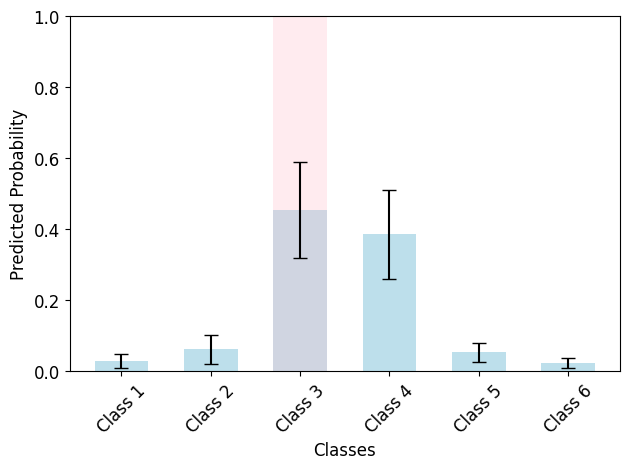

In [79]:
classes = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']
mean_predict_plot = mean_predict[PLOT]
std_predict_plot = sd_predict[PLOT]
truth_plot = y_test.loc[PLOT].values[0]

# Plotting
fig, ax = plt.subplots()


# Bar plot for mean predicted probabilities
bar_width = 0.6
bars = ax.bar(classes, mean_predict_plot, yerr=std_predict_plot, capsize=5, color='lightblue', alpha=0.8, width=bar_width)
ax.bar(classes[truth_plot], 1, color='pink', alpha=0.3, width=bar_width)

# Adding titles and labels
ax.set_xlabel('Classes', fontsize=12)
ax.set_ylabel('Predicted Probability', fontsize=12)
ax.set_ylim(0, 1)  # Ensuring the y-axis ranges from 0 to 1

# Show the plot
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [80]:
gbt_explanation_lime = gbt_model.explain_lime(X_test.loc[[PLOT]])

 50/157 [========>.....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ trea

 66/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 45/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 62/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 86/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 46/157 [=======>......................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 86/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 94/157 [================>.............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 95/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 97/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 88/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 74/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 94/157 [================>.............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 97/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

101/157 [==================>...........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 93/157 [================>.............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 52/157 [========>.....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 78/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

101/157 [==================>...........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

105/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 79/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 89/157 [================>.............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 56/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 97/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 89/157 [================>.............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 60/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 70/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 97/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 93/157 [================>.............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 58/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 56/157 [=========>....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 90/157 [================>.............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 98/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 88/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 52/157 [========>.....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 78/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 95/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 95/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 83/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 51/157 [========>.....................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 43/157 [=======>......................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 70/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 68/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 96/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

102/157 [==================>...........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 98/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 67/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 95/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 80/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 83/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

102/157 [==================>...........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 91/157 [================>.............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 65/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 26/157 [===>..........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 82/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 96/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

104/157 [==================>...........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 89/157 [================>.............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 96/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 78/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 96/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 65/157 [===========>..................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 94/157 [================>.............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 87/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 76/157 [=============>................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 37/157 [======>.......................] - ETA: 0s 

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 73/157 [============>.................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 91/157 [================>.............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 80/157 [==============>...............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 95/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 89/157 [================>.............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

105/157 [===================>..........] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 95/157 [=================>............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 85/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 87/157 [===============>..............] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 30/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 60/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 58/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 61/157 [==========>...................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

 31/157 [====>.........................] - ETA: 0s

/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

157/157 [==============================] - 0s 1ms/step


/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/Users/ygao/Library/Caches/pypoetry/virtualenvs/program-i-Fez0zm-py3.10/lib/python3.10/site-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ trea

In [81]:
gbt_explanation_shap=gbt_model.explain_shap(X_test.loc[[PLOT]])

In [276]:
for i, explanation in enumerate(gbt_explanation_lime):
    print(f"Explanation {i + 1}:")
    print("As List of Tuples (feature_id, weight):")
    for feature_id, weight in explanation.as_list():
        print(f"Feature {feature_id}: {weight}")

    print("\n")

Explanation 1:
As List of Tuples (feature_id, weight):
Feature pH > 0.58: 0.017892209584409294
Feature fixed acidity > 0.51: 0.008436730834158022
Feature sulphates > 0.42: -0.005740592947002896
Feature free sulfur dioxide > 0.54: 0.004861332792311368
Feature volatile acidity > 0.61: 0.0037410887659170776
Feature total sulfur dioxide > 0.46: 0.003492116150480877
Feature -0.06 < citric acid <= 0.80: -0.0032255088898253195
Feature residual sugar > 0.05: 0.001984101346138859
Feature alcohol > 0.59: 0.001333666222415489
Feature density > 0.58: -0.0007566092598251247
Feature chlorides > 0.05: -0.0004663284558798496


Explanation 2:
As List of Tuples (feature_id, weight):
Feature pH > 0.58: 0.02312904824867024
Feature volatile acidity > 0.61: 0.011954582579777833
Feature sulphates > 0.42: -0.009955383766836197
Feature chlorides > 0.05: -0.007019666963270756
Feature fixed acidity > 0.51: 0.006944418285470597
Feature -0.06 < citric acid <= 0.80: -0.003761824687769559
Feature total sulfur dioxid

In [45]:
print(gbt_explanation_shap[0])
values_try = gbt_explanation_shap[0].values
print(values_try)

.values =
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.85342688e-04,  6.23859985e-02, -7.89320052e-02,
          2.49150769e-02, -4.81943137e-03, -4.13498079e-03],
        [-1.37394859e-04, -9.72069227e-04,  6.41168593e-03,
         -1.90100830e-04, -4.00209614e-03, -1.11002333e-03],
        [ 5.68800941e-04, -5.38080246e-03, -2.23806675e-02,
          5.39670995e-02, -2.10748604e-02, -5.69955971e-03],
        [ 2.18894805e-05,  1.54344749e-04,  6.72355365e-04,
         -5.79773936e-04, -4.46620988e-04,  1.77805805e-04],
        [ 4.38116624e-06,  2.41569430e-05, -1.10284465e-03,
          6.02694991e-05,  9.76497503e-04,  3.75389929e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+

In [82]:
feature_weights = defaultdict(list)

for explanation in gbt_explanation_lime:
    for feature, weight in explanation.as_list():
        feature_weights[feature].append(weight)

feature_stats = {}
for feature, weights in feature_weights.items():
    mean_weight = np.mean(weights)
    std_weight = np.std(weights)
    feature_stats[feature] = {'mean': mean_weight, 'std': std_weight}

print(feature_stats)

{'free sulfur dioxide > 0.54': {'mean': 0.008023737277830048, 'std': 0.008256117673045273}, 'volatile acidity > 0.61': {'mean': 0.014664595274656462, 'std': 0.006728423583914425}, 'pH > 0.58': {'mean': 0.01956269885512895, 'std': 0.007526723927276504}, 'density > 0.58': {'mean': 0.004176147394234583, 'std': 0.004925529012997777}, 'total sulfur dioxide > 0.46': {'mean': -0.0029087173876280402, 'std': 0.004005138534902354}, 'chlorides > 0.05': {'mean': -0.003095194980957437, 'std': 0.0043345830975475225}, 'residual sugar > 0.05': {'mean': 0.0016347873127856981, 'std': 0.0032843396579916783}, 'fixed acidity > 0.51': {'mean': 0.006256200583023239, 'std': 0.005063515311316678}, '-0.06 < citric acid <= 0.80': {'mean': -0.0021637025203111865, 'std': 0.0020178219690036784}, 'sulphates > 0.42': {'mean': -0.006573897126449339, 'std': 0.0039053189502456834}, 'alcohol > 0.59': {'mean': 0.0004912554429400712, 'std': 0.004623273345484354}}


In [83]:
feature_order = X_test.columns.tolist()
def sort_key(x):
    for op in [' >= ', ' <= ', ' > ', ' < ', ' = ']:
        if op in x:
            return feature_order.index(x.split(op)[0])
        
sorted_keys = sorted(feature_stats.keys(), key=sort_key)
sorted_feature_stats = {key: feature_stats[key] for key in sorted_keys}

print(sorted_feature_stats)

ValueError: '-0.06 < citric acid' is not in list

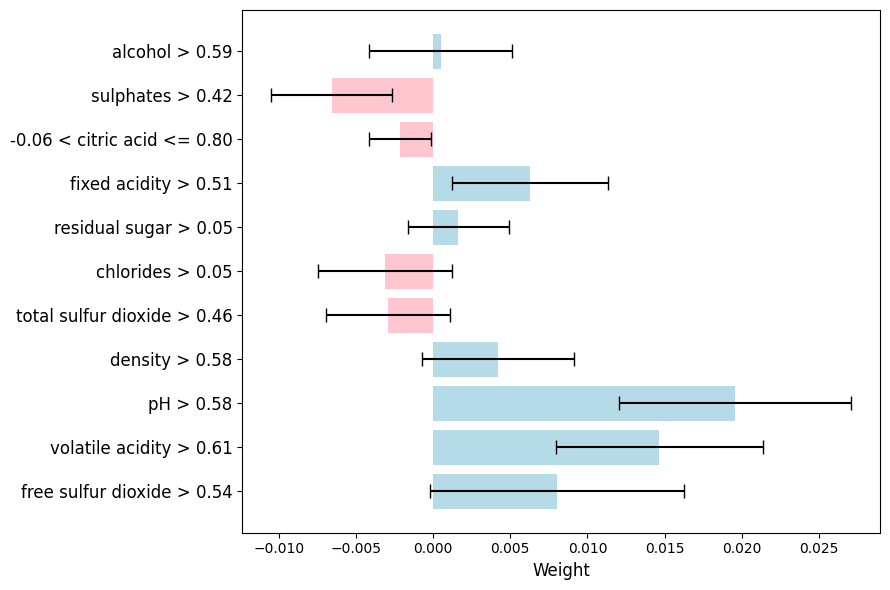

weights [0.008023737277830048, 0.014664595274656462, 0.01956269885512895, 0.004176147394234583, -0.0029087173876280402, -0.003095194980957437, 0.0016347873127856981, 0.006256200583023239, -0.0021637025203111865, -0.006573897126449339, 0.0004912554429400712] sd [0.008256117673045273, 0.006728423583914425, 0.007526723927276504, 0.004925529012997777, 0.004005138534902354, 0.0043345830975475225, 0.0032843396579916783, 0.005063515311316678, 0.0020178219690036784, 0.0039053189502456834, 0.004623273345484354]


In [84]:
features = list(feature_stats.keys())
mean_weights = [feature_stats[feature]['mean'] for feature in features]
std_weights = [feature_stats[feature]['std'] for feature in features]

colors = ['lightblue' if weight > 0 else 'pink' for weight in mean_weights]

feature_ids = range(len(mean_weights))
plt.figure(figsize=(9, 6))
plt.barh(feature_ids, mean_weights, xerr=std_weights, capsize=5, alpha=0.9, color=colors)
plt.yticks(feature_ids, features, fontsize=12)
plt.xlabel("Weight", fontsize=12)
plt.tight_layout()
plt.show()

print("weights", mean_weights, "sd", std_weights)

In [85]:
shap_features = X_test.loc[[PLOT]].columns.tolist()

In [86]:
# Check the length of gbt_explanation_shap
print("Number of SHAP explanation objects:", len(gbt_explanation_shap))

# Attempt to stack SHAP values
stacked_shap_values = np.vstack([gbt_explanation_shap[i].values for i in range(len(gbt_explanation_shap))])

# Print the stacked SHAP values
print("Shape of stacked SHAP values:", stacked_shap_values.shape)
print("Stacked SHAP values:\n", stacked_shap_values)

Number of SHAP explanation objects: 80
Shape of stacked SHAP values: (80, 11, 6)
Stacked SHAP values:
 [[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 5.86104186e-04  6.23969773e-02 -7.89318933e-02  2.48799877e-02
   -4.79997312e-03 -4.13120489e-03]
  [-1.37674467e-04 -9.75127768e-04  6.41109599e-03 -1.79129740e-04
   -4.00778018e-03 -1.11138169e-03]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-2.52542511e-04 -1.68127421e-03  1.43542517e-02 -3.55521594e-03
   -6.80501878e-03 -2.06018513e-03]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.63745100e-03  1.18485801e-03 -8.52144467e-03  3.92724910e-03
    1.49902501e-03  2.72862947e-04]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+0

In [87]:
mean_shap_values = np.mean(stacked_shap_values, axis=0)

# Calculate standard deviation of SHAP values across the 80 explanations
sd_shap_values = np.std(stacked_shap_values, axis=0)

# Now you have mean_shap_values and sd_shap_values
print("Mean SHAP values shape:", mean_shap_values.shape)
print("Standard deviation of SHAP values shape:", sd_shap_values.shape)
print(mean_shap_values)

Mean SHAP values shape: (11, 6)
Standard deviation of SHAP values shape: (11, 6)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.61615333e-04 -1.67985470e-03  3.13273296e-03  6.33866413e-04
  -2.15014855e-03 -1.98207379e-04]
 [ 6.17378328e-05  1.17869885e-04 -2.01851023e-03  6.69848993e-04
   3.70500859e-04  7.98555029e-04]
 [ 4.01430540e-04 -1.69238652e-03 -5.21097849e-03  3.78609772e-04
   5.78179775e-03  3.41528809e-04]
 [-1.96979203e-05 -1.40561190e-04  4.64205053e-04 -3.12033597e-04
   4.57502599e-04 -4.49415014e-04]
 [-2.27393526e-06  2.71693610e-05 -2.30829415e-04 -8.54550378e-05
   2.63638888e-04  2.77501186e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.17188941e-08 -2.25265527e-07 -5.95028933e-06  9.71956320e-06
  -9.33898835e-07 -2.56839514e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.84751

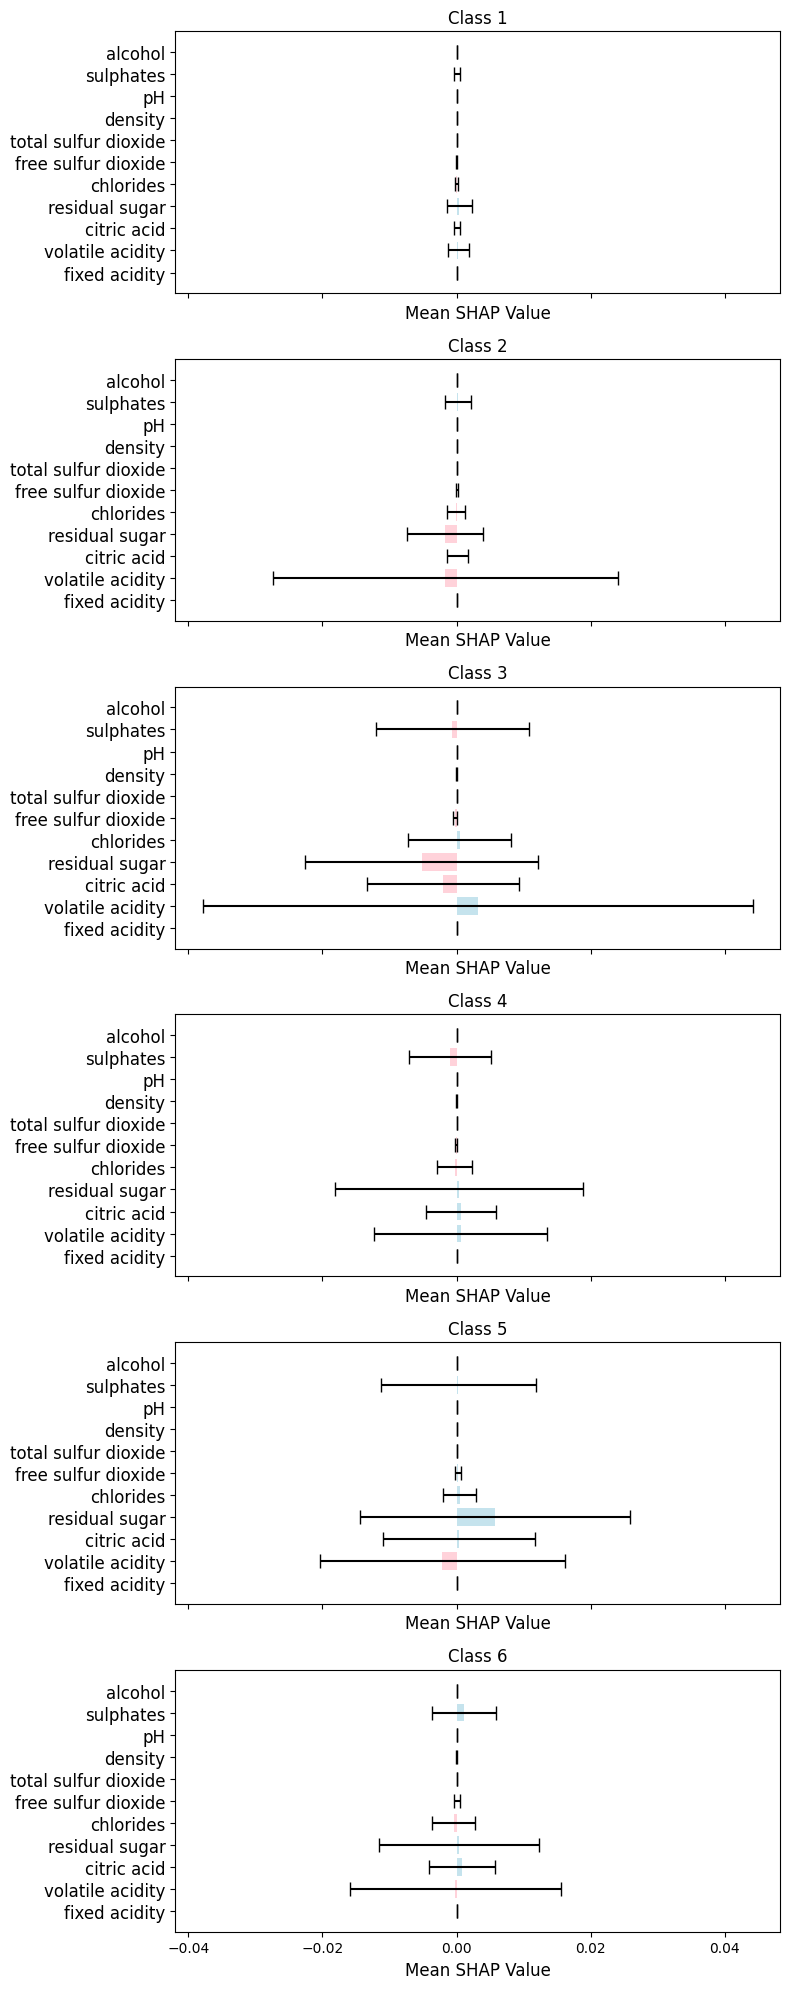

In [88]:
num_features, num_classes = mean_shap_values.shape
colors = np.where(mean_shap_values >= 0, 'lightblue', 'pink')

feature_ids = range(len(mean_shap_values))
# Plotting each class separately
fig, axs = plt.subplots(num_classes, figsize=(8, 20), sharex=True)

for cls in range(num_classes):
    ax = axs[cls]
    ax.barh(np.arange(num_features), mean_shap_values[:, cls], xerr=sd_shap_values[:, cls], align='center', alpha=0.7, capsize=5, color=colors[:, cls])
    ax.set_yticks(feature_ids, shap_features, fontsize=12)
    ax.set_title(f'Class {cls+1}')
    ax.set_xlabel('Mean SHAP Value', fontsize=12)
    ax.grid(False)

plt.tight_layout()
plt.show()

In [92]:
# Compute absolute sum across classes (axis=2)
absolute_sum_shap_values = np.abs(stacked_shap_values).sum(axis=2)

# Print the shape of the absolute sum SHAP values
print("Shape of absolute sum SHAP values:", absolute_sum_shap_values.shape)

mean_shap_sum = np.mean(absolute_sum_shap_values, axis=0)

# Calculate standard deviation of SHAP values across the 80 explanations
sd_shap_sum = np.std(absolute_sum_shap_values, axis=0)

# Now you have mean_shap_values and sd_shap_values
print("Mean SHAP values shape:", mean_shap_sum.shape)
print("Standard deviation of SHAP values shape:", sd_shap_sum.shape)

Shape of absolute sum SHAP values: (80, 11)
Mean SHAP values shape: (11,)
Standard deviation of SHAP values shape: (11,)


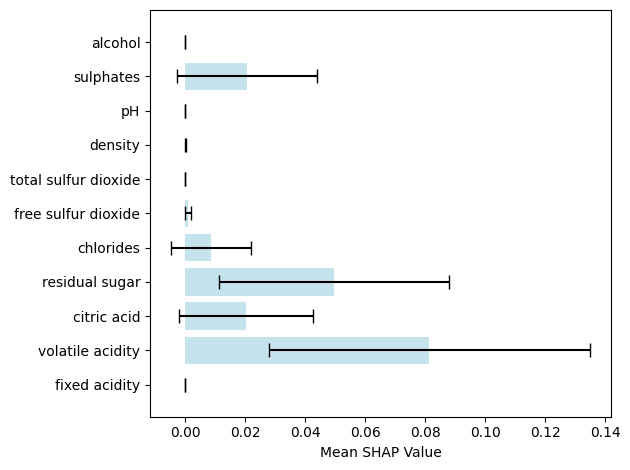

In [94]:
# Plotting
fig, ax = plt.subplots()

# Plot bars for mean SHAP values
bars = ax.barh(shap_features, mean_shap_sum, xerr=sd_shap_sum, align='center', color='lightblue',alpha=0.7, capsize=5)

# Adding labels and title
ax.set_xlabel('Mean SHAP Value')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# predict gives the class number
# make a histogram of the class prediction
# entropy to measure the uncertainty